In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
class Vae(nn.Module):
    def __init__(self):
        super(Vae,self).__init__()
        
        self.encoder  = nn.Sequential(
                nn.Conv2d(1,32,3),
                nn.LeakyReLU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(32,64,3),
                nn.LeakyReLU(),
                
                nn.BatchNorm2d(64),
                nn.Conv2d(64,64,3),
                nn.LeakyReLU(),
                nn.BatchNorm2d(64),
                nn.Conv2d(64,64,3),
                nn.LeakyReLU(),
                nn.BatchNorm2d(64))
        self.mu      = nn.Linear(64*20*20,2)
        self.log_var = nn.Linear(64*20*20,2)
        self.n       = torch.distributions.Normal(0,1)
        self.n.loc   = self.n.loc.cuda()
        self.n.scale = self.n.scale.cuda()
        
        self.decoder = nn.Sequential(
                    nn.Linear(2,64*20*20),
                    nn.Unflatten(1,(64,20,20)),
                    nn.ConvTranspose2d(64,64,3),
                    nn.LeakyReLU(),
                    nn.BatchNorm2d(64),
                    nn.ConvTranspose2d(64,64,3),
                    nn.LeakyReLU(),
                    nn.BatchNorm2d(64),
                    nn.ConvTranspose2d(64,32,3),
                    nn.LeakyReLU(),
                    nn.BatchNorm2d(32),
                    nn.ConvTranspose2d(32,1,3),
                    nn.Sigmoid()
                    )
        
        
    def forward(self,x):
        x= self.encoder(x)
        #print(x.shape)
        mu= self.mu(torch.flatten(x,1))
        log_var= self.log_var(torch.flatten(x,1))
        sigma= torch.exp(log_var/2)
        z= mu+sigma*self.n.sample(mu.shape)
        #print(encoded.shape)
        decoded= self.decoder(z)
        return decoded

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

In [18]:
model = Vae(28,2).to(device)

In [19]:
optimizer= optim.Adam(model.parameters(),lr=1e-5)
criterion= nn.MSELoss()

In [20]:
for epoch in range(50):
    size = len(trainloader.dataset)
    for batch,(x,Y) in enumerate(trainloader):
        x_train,y_train= x.to(device),x.to(device)
        y_pred= model(x_train)
        loss= criterion(y_pred,y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 1000==0:
            loss, current = loss.item(), batch * len(x_train)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]",f"epoch: {epoch}")

loss: 1.968838  [    0/60000] epoch: 0
loss: 1.136445  [    0/60000] epoch: 1
loss: 1.101152  [    0/60000] epoch: 2
loss: 1.095571  [    0/60000] epoch: 3
loss: 1.029441  [    0/60000] epoch: 4
loss: 1.010222  [    0/60000] epoch: 5
loss: 0.996658  [    0/60000] epoch: 6
loss: 0.975578  [    0/60000] epoch: 7
loss: 0.967444  [    0/60000] epoch: 8
loss: 0.953682  [    0/60000] epoch: 9
loss: 0.941262  [    0/60000] epoch: 10
loss: 0.944279  [    0/60000] epoch: 11
loss: 0.943356  [    0/60000] epoch: 12
loss: 0.929082  [    0/60000] epoch: 13
loss: 0.920995  [    0/60000] epoch: 14
loss: 0.920812  [    0/60000] epoch: 15
loss: 0.917386  [    0/60000] epoch: 16
loss: 0.922759  [    0/60000] epoch: 17
loss: 0.922204  [    0/60000] epoch: 18
loss: 0.921717  [    0/60000] epoch: 19
loss: 0.918988  [    0/60000] epoch: 20
loss: 0.913932  [    0/60000] epoch: 21
loss: 0.912655  [    0/60000] epoch: 22
loss: 0.914906  [    0/60000] epoch: 23
loss: 0.908760  [    0/60000] epoch: 24
loss: 0.90

In [21]:
torch.save(model.state_dict(), "variationalautoencoder.pt")

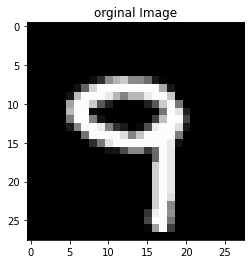

In [24]:
for batch,(x,Y) in enumerate(testloader):
    item = x.reshape(-1, 28, 28)
    reconstructed= model(x.to(device))
    generate= reconstructed.cpu()
    plt.imshow(item[0],cmap='gray')
    plt.title("orginal Image")

Text(0.5, 1.0, 'generated image')

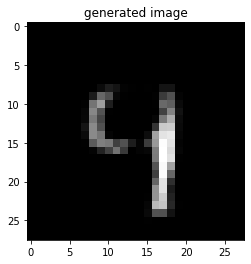

In [25]:
plt.imshow(generate.data[0].squeeze(),cmap='gray')
plt.title('generated image')

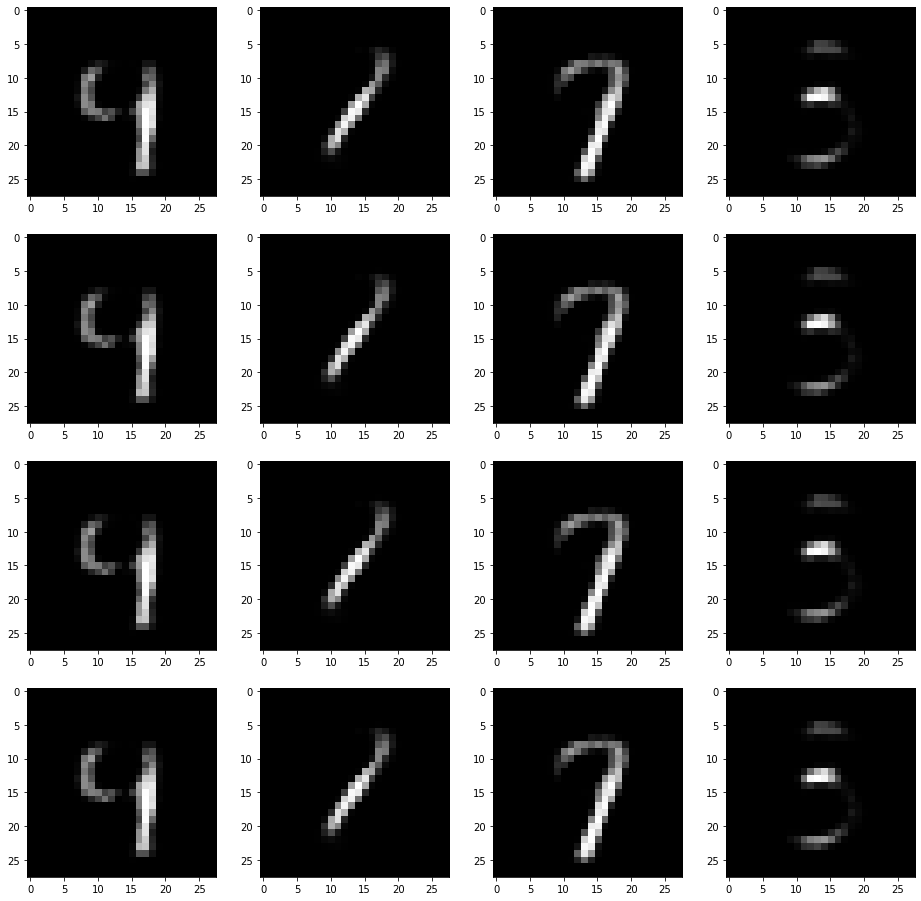

In [26]:
fig,axs = plt.subplots(4,4,figsize=(16, 16))
for i in range(4):
    for j in range(4):
        img = generate.data[j].squeeze()
        axs[i][j].imshow(img,cmap='gray')

In [32]:
import numpy as np
def plot_ae_outputs(model,n=10):
    plt.figure(figsize=(16,4.5))
    targets = testset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = testset[t_idx[i]][0].unsqueeze(0).to(device)
      model.eval()
      with torch.no_grad():
         rec_img  = model(img)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

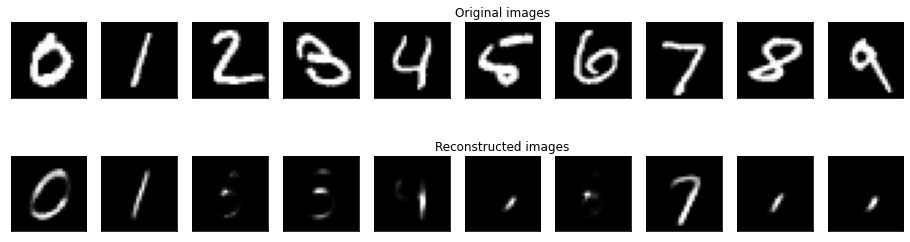

In [33]:
plot_ae_outputs(model,n=10)